# Домашнее задание № 8

# Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [ ]:
!pip install pandas scikit-learn matplotlib

In [84]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import backend as K

In [85]:
from tqdm import tqdm

In [86]:
data = pd.read_csv('lenta_40k.csv.zip')

In [87]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [88]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [89]:
vocab = Counter()

for text in tqdm(data.text):
    vocab.update(preprocess(text))

100%|██████████| 44356/44356 [00:03<00:00, 11434.41it/s]


In [90]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [91]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [92]:
id2word = {i:word for word, i in word2id.items()}

In [93]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [94]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [95]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [96]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [97]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [98]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

## 1 GRU слой

In [99]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

dense = tf.keras.layers.Dense(64, activation='relu')(gru)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model1.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

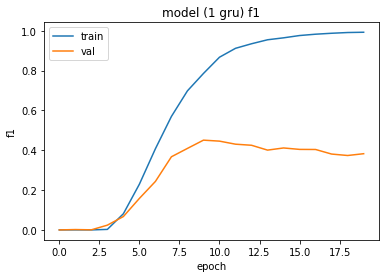

In [101]:
plt.plot(model1.history.history['rec@prec'])
plt.plot(model1.history.history['val_rec@prec'])
plt.title('model (1 gru) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [103]:
# словари для f1
f1_train = {}
f1_val = {}

In [104]:
f1_train['f1_gru'] = float('{:.2f}'.format(model1.history.history['f1'][-1]))
f1_val['f1_gru'] = float('{:.2f}'.format(model1.history.history['val_f1'][-1]))

In [107]:
f1_train, f1_val

({'f1_gru': 0.98}, {'f1_gru': 0.61})

## 1 Lstm слой

In [108]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model2.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

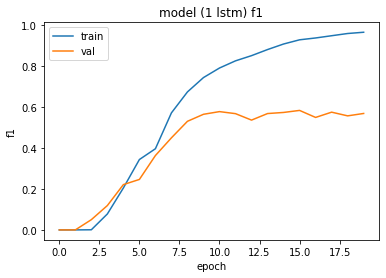

In [110]:
plt.plot(model2.history.history['rec@prec'])
plt.plot(model2.history.history['val_rec@prec'])
plt.title('model (1 lstm) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [111]:
f1_train['f1 1 lstm'] = float('{:.2f}'.format(model2.history.history['f1'][-1]))
f1_val['f1 1 lstm'] = float('{:.2f}'.format(model2.history.history['val_f1'][-1]))

In [112]:
f1_train, f1_val

({'f1_gru': 0.98, 'f1 1 lstm': 0.93}, {'f1_gru': 0.61, 'f1 1 lstm': 0.67})

## 1 GRU и 1 LSTM слои

In [113]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm = tf.keras.layers.LSTM(128, return_sequences=False)(gru)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model3.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

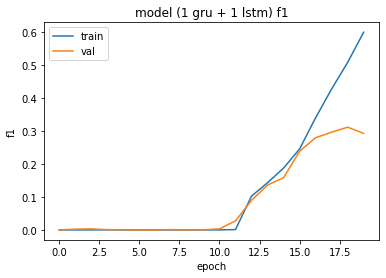

In [115]:
plt.plot(model3.history.history['rec@prec'])
plt.plot(model3.history.history['val_rec@prec'])
plt.title('model (1 gru + 1 lstm) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [118]:
f1_train['f1 1 gru + 1 lstm'] = float('{:.2f}'.format(model3.history.history['f1'][-1]))
f1_val['f1 1 gru + 1 lstm'] = float('{:.2f}'.format(model3.history.history['val_f1'][-1]))

In [ ]:
f1_train, f1_val

## 1 BIGRU и 2 LSTM слои

In [121]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm1 = tf.keras.layers.LSTM(128, return_sequences=True)(bigru)
lstm2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model4 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model4.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

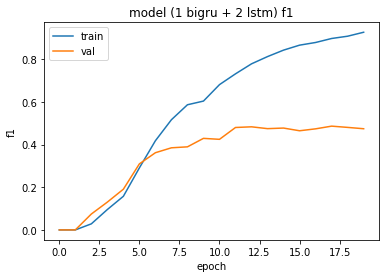

In [123]:
plt.plot(model4.history.history['rec@prec'])
plt.plot(model4.history.history['val_rec@prec'])
plt.title('model (1 bigru + 2 lstm) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [124]:
f1_train['f1 1 bigru + 2 lstm'] = float('{:.2f}'.format(model4.history.history['f1'][-1]))
f1_val['f1 1 bigru + 2 lstm'] = float('{:.2f}'.format(model4.history.history['val_f1'][-1]))

In [ ]:
f1_train, f1_val

## 5 GRU и 3 LSTM слоя

In [126]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru2 = tf.keras.layers.GRU(128, return_sequences=True)(gru1)
gru3 = tf.keras.layers.GRU(128, return_sequences=True)(gru2)
gru4 = tf.keras.layers.GRU(128, return_sequences=True)(gru3)
gru5 = tf.keras.layers.GRU(128, return_sequences=True)(gru4)

lstm1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru5)
lstm2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm1)
lstm3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model5 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model5.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model5.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

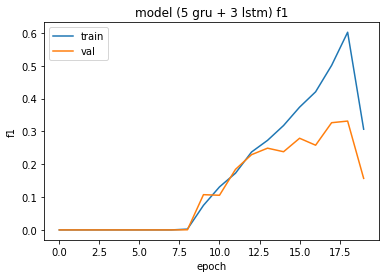

In [128]:
plt.plot(model5.history.history['rec@prec'])
plt.plot(model5.history.history['val_rec@prec'])
plt.title('model (5 gru + 3 lstm) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [129]:
f1_train['f1 5 gru + 3 lstm'] = float('{:.2f}'.format(model5.history.history['f1'][-1]))
f1_val['f1 5 gru + 3 lstm'] = float('{:.2f}'.format(model5.history.history['val_f1'][-1]))

In [ ]:
f1_train, f1_val

## 1 BIGRU и 1 BILSTM

In [131]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru_bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False),
                                             backward_layer=tf.keras.layers.LSTM(128, return_sequences=False, 
                                                                                 go_backwards=True))(embeddings)

dense = tf.keras.layers.Dense(64, activation='relu')(bigru_bilstm)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model6.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model6.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

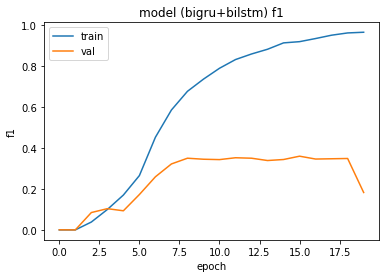

In [133]:
plt.plot(model6.history.history['rec@prec'])
plt.plot(model6.history.history['val_rec@prec'])
plt.title('model (bigru+bilstm) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [134]:
f1_train['bigru+bilstm'] = float('{:.2f}'.format(model6.history.history['f1'][-1]))
f1_val['bigru+bilstm'] = float('{:.2f}'.format(model6.history.history['val_f1'][-1]))

In [ ]:
f1_train, f1_val

##  LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [146]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm1)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru1)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bilstm)
gru2 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)
lstm2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model7 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model7.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model7.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

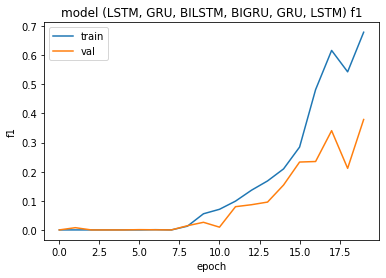

In [148]:
plt.plot(model7.history.history['rec@prec'])
plt.plot(model7.history.history['val_rec@prec'])
plt.title('model (LSTM, GRU, BILSTM, BIGRU, GRU, LSTM) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [150]:
f1_train['LSTM, GRU, BILSTM, BIGRU, GRU, LSTM'] = float('{:.2f}'.format(model7.history.history['f1'][-1]))
f1_val['LSTM, GRU, BILSTM, BIGRU, GRU, LSTM'] = float('{:.2f}'.format(model7.history.history['val_f1'][-1]))

## Итоги

In [151]:
f1_df = pd.DataFrame.from_dict(f1_train, orient='index', columns=['f1-score'])
f1_val_df = pd.DataFrame.from_dict(f1_val, orient='index', columns=['f1-score'])

In [152]:
f1_df.sort_values(by=['f1-score'], ascending=False)

,f1-score
f1_gru,0.98
f1 1 lstm,0.93
bigru+bilstm,0.92
f1 1 bigru + 2 lstm,0.89
"LSTM, GRU, BILSTM, BIGRU, GRU, LSTM",0.73
f1 1 gru + 1 lstm,0.70
f1 5 gru + 3 lstm,0.53


In [153]:
f1_val_df.sort_values(by=['f1-score'], ascending=False)

,f1-score
f1 1 lstm,0.67
f1 1 bigru + 2 lstm,0.66
f1_gru,0.61
"LSTM, GRU, BILSTM, BIGRU, GRU, LSTM",0.59
f1 1 gru + 1 lstm,0.57
bigru+bilstm,0.55
f1 5 gru + 3 lstm,0.47


Для каждой модели я смотрела f1-score на валидации на последней эпохе. Самый высокий f1-score у модели с одним LSTM слоем, чуть хуже у модели с 1 bidirectional GRU и двумя LSTM слоями.

Хуже всего результат у модели с самым большим числом слоев: 5 GRU и 3 LSTM.



# Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
!pip install datasets

In [50]:
from datasets import load_dataset
from sklearn.metrics import classification_report
import re

In [ ]:
dataset = load_dataset("wikiann", 'ru')

In [9]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [11]:
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [23]:
X_train = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_train.append(ids)

In [24]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [25]:
MAX_LEN = max(len(x) for x in X)

In [26]:
MAX_LEN

54

In [27]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [28]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [29]:
y_train = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [31]:
y_train.shape, y_test.shape

((20000, 54), (10000, 54))

### Модель с несколькими bilstm слоями


In [34]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model_21 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_21.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [ ]:
model_21.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

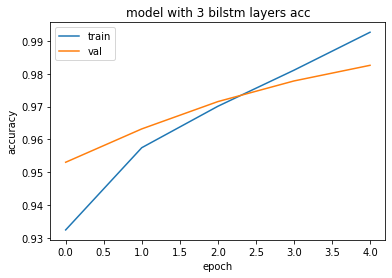

In [38]:
plt.plot(model_21.history.history['accuracy'])
plt.plot(model_21.history.history['val_accuracy'])
plt.title('model with 3 bilstm layers acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
y_preds = model_21.predict(X_test).argmax(2)

313/313 [==============================] - 8s 15ms/step


In [43]:
print(classification_report(y_test.reshape(-1), y_preds.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.93      0.95      0.94     40480
       B-PER       0.80      0.73      0.76      3542
       I-PER       0.93      0.83      0.88      7544
       B-ORG       0.63      0.70      0.66      4074
       I-ORG       0.81      0.78      0.80      8008
       B-LOC       0.73      0.68      0.70      4560
       I-LOC       0.64      0.75      0.69      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.81      0.80      0.80    540000
weighted avg       0.98      0.98      0.98    540000



### Модель с несколькими BIGRU слоями.

In [44]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_1)
bigru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru_3)

model_22 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_22.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [ ]:
model_22.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

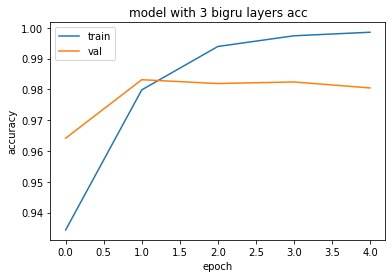

In [46]:
plt.plot(model_22.history.history['accuracy'])
plt.plot(model_22.history.history['val_accuracy'])
plt.title('model with 3 bigru layers acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
y_preds2 = model_22.predict(X_test).argmax(2)

313/313 [==============================] - 5s 9ms/step


In [48]:
print(classification_report(y_test.reshape(-1), y_preds2.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.95      0.92      0.93     40480
       B-PER       0.93      0.69      0.79      3542
       I-PER       0.95      0.74      0.83      7544
       B-ORG       0.49      0.80      0.60      4074
       I-ORG       0.72      0.82      0.77      8008
       B-LOC       0.67      0.77      0.72      4560
       I-LOC       0.90      0.69      0.78      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.82      0.80      0.80    540000
weighted avg       0.98      0.98      0.98    540000



Судя по метрикам, качество моделей практически не отличается: первая модель чуть лучше предсказывает организации (B-ORG и I-ORG), у второй чуть выше показатели на местах (B-LOC и I-LOC), но значение взвешенного f-1 score = 0.98 для обеих моделей. 
Проверим, так ли это, на нескольких реальных примерах.

In [49]:
def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

### Предсказания именованных сущностей

In [65]:
label_seq('Таня, Маша, Даша, Ксюша, Анна Петровна, юра', word2id, id2labels, MAX_LEN, model_21)

1/1 [==============================] - 0s 28ms/step


[('Таня', 'B-PER'),
 (',', 'I-PER'),
 ('Маша', 'I-PER'),
 (',', 'O'),
 ('Даша', 'O'),
 (',', 'O'),
 ('Ксюша', 'O'),
 (',', 'O'),
 ('Анна', 'B-PER'),
 ('Петровна', 'I-PER'),
 (',', 'O'),
 ('юра', 'I-PER')]

In [66]:
label_seq('Таня, Маша, Даша, Ксюша, Анна Петровна, юра', word2id, id2labels, MAX_LEN, model_22)

1/1 [==============================] - 0s 27ms/step


[('Таня', 'B-PER'),
 (',', 'O'),
 ('Маша', 'I-PER'),
 (',', 'O'),
 ('Даша', 'B-PER'),
 (',', 'O'),
 ('Ксюша', 'B-LOC'),
 (',', 'O'),
 ('Анна', 'B-PER'),
 ('Петровна', 'I-PER'),
 (',', 'O'),
 ('юра', 'O')]

- Обе модели не считают Ксюшу человеком :( Модель с bilstm просто не определила ее как именованную сущность (как и Дашу), модель с bigru приняла ее за место. 
- Bilstm модель определила запятую как PER, что странно.
- Bigru модель не распознала юру с маленькой буквы, bilstm распознала как I-PER
- Обе модели верно распознали Анну Петровну (B-PER + I-PER)

In [67]:
label_seq('Премьер-министр Великобритании Сунак подписал договор.', word2id, id2labels, MAX_LEN, model_21)

1/1 [==============================] - 0s 36ms/step


[('Премьер', 'B-ORG'),
 ('-', 'O'),
 ('министр', 'B-ORG'),
 ('Великобритании', 'I-ORG'),
 ('Сунак', 'I-ORG'),
 ('подписал', 'I-ORG'),
 ('договор', 'I-ORG'),
 ('.', 'O')]

In [68]:
label_seq('Премьер-министр Великобритании Сунак подписал договор.', word2id, id2labels, MAX_LEN, model_22)

1/1 [==============================] - 0s 27ms/step


[('Премьер', 'B-ORG'),
 ('-', 'O'),
 ('министр', 'O'),
 ('Великобритании', 'B-ORG'),
 ('Сунак', 'I-ORG'),
 ('подписал', 'O'),
 ('договор', 'B-ORG'),
 ('.', 'O')]

Здесь у обеих моделей все плохо - почти все распознают как ORG, и страну, и человека, и неименованные сущности, вроде договора.

In [78]:
label_seq('МГЛУ имени Мориса Тореза - лучший лингвистический университет в Москве.', word2id, id2labels, MAX_LEN, model_21)

1/1 [==============================] - 0s 38ms/step


[('МГЛУ', 'B-ORG'),
 ('имени', 'I-ORG'),
 ('Мориса', 'I-ORG'),
 ('Тореза', 'I-ORG'),
 ('-', 'O'),
 ('лучший', 'O'),
 ('лингвистический', 'O'),
 ('университет', 'B-ORG'),
 ('в', 'O'),
 ('Москве', 'B-ORG'),
 ('.', 'O')]

In [80]:
label_seq('МГЛУ имени Мориса Тореза - лучший лингвистический университет в Москве.', word2id, id2labels, MAX_LEN, model_22)

1/1 [==============================] - 0s 71ms/step


[('МГЛУ', 'B-ORG'),
 ('имени', 'I-ORG'),
 ('Мориса', 'I-ORG'),
 ('Тореза', 'I-ORG'),
 ('-', 'O'),
 ('лучший', 'O'),
 ('лингвистический', 'B-ORG'),
 ('университет', 'I-ORG'),
 ('в', 'O'),
 ('Москве', 'B-LOC'),
 ('.', 'O')]

А здесь обе справились с полным названием организации! Второй модели удалось верно предсказать Москву как LOC.

In [71]:
label_seq('В столице Испании Мадриде состоялась выставка Пикассо.', word2id, id2labels, MAX_LEN, model_21)

1/1 [==============================] - 0s 30ms/step


[('В', 'O'),
 ('столице', 'O'),
 ('Испании', 'B-LOC'),
 ('Мадриде', 'O'),
 ('состоялась', 'O'),
 ('выставка', 'O'),
 ('Пикассо', 'B-LOC'),
 ('.', 'O')]

In [72]:
label_seq('В столице Испании Мадриде состоялась выставка Пикассо.', word2id, id2labels, MAX_LEN, model_22)

1/1 [==============================] - 0s 31ms/step


[('В', 'O'),
 ('столице', 'O'),
 ('Испании', 'B-ORG'),
 ('Мадриде', 'I-ORG'),
 ('состоялась', 'O'),
 ('выставка', 'O'),
 ('Пикассо', 'B-ORG'),
 ('.', 'O')]

- Модель с Bigru не предсказала ни места, ни человека - все определила как ORG.
- Модель с Bilstm почему-то определила Испанию, но не определила Мадрид. Пикассо определили как именованную сущность, но не PER, а LOC.

In [76]:
label_seq('Франсиско Франко был диктатором Испании в 20 веке.', word2id, id2labels, MAX_LEN, model_21)

1/1 [==============================] - 0s 94ms/step


[('Франсиско', 'B-PER'),
 ('Франко', 'I-PER'),
 ('был', 'O'),
 ('диктатором', 'O'),
 ('Испании', 'B-ORG'),
 ('в', 'O'),
 ('20', 'B-PER'),
 ('веке', 'I-PER'),
 ('.', 'O')]

In [77]:
label_seq('Франсиско Франко был диктатором Испании в 20 веке.', word2id, id2labels, MAX_LEN, model_22)

1/1 [==============================] - 0s 32ms/step


[('Франсиско', 'B-PER'),
 ('Франко', 'I-PER'),
 ('был', 'O'),
 ('диктатором', 'B-ORG'),
 ('Испании', 'I-ORG'),
 ('в', 'O'),
 ('20', 'B-ORG'),
 ('веке', 'I-ORG'),
 ('.', 'O')]

In [81]:
label_seq('Сан-Франциско - город диско', word2id, id2labels, MAX_LEN, model_21)

1/1 [==============================] - 0s 82ms/step


[('Сан', 'B-PER'),
 ('-', 'O'),
 ('Франциско', 'I-PER'),
 ('-', 'O'),
 ('город', 'O'),
 ('диско', 'O')]

In [82]:
label_seq('Сан-Франциско - город диско', word2id, id2labels, MAX_LEN, model_22)

1/1 [==============================] - 0s 43ms/step


[('Сан', 'B-ORG'),
 ('-', 'O'),
 ('Франциско', 'O'),
 ('-', 'O'),
 ('город', 'O'),
 ('диско', 'B-LOC')]

Чисто теоретически, Сан-Франциско действительно может оказаться Святым Франциском - наверное, первая модель (bilstm) справилась здесь лучше.

### Выводы

- Предсказания обеих моделей далеки от идеала - чувствуется, что для обучения был взят корпус Википедии, так как исторических личностей они предсказывают гораздо лучше, чем простые имена вроде Ксюши или Юры.
- По метрикам самыми низкими были предсказания организаций - возможно потому, что слишком часто другие именованные (и неименованные) сущности предсказываются как ORG.
- С PER лучше справляется модель с bilstm, с LOC скорее вторая модель.